In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from qlstm_pennylane import QLSTM
import pandas as pd

In [28]:
data=pd.read_csv('Sindata.csv')
data

,Wave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402
...,...
4996,0.680667
4997,0.725324
4998,0.767118
4999,0.805885


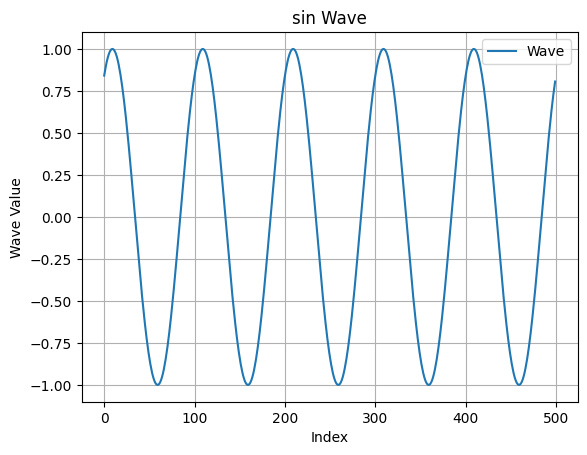

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

dataa = data["Wave"][:500]

# Plot the data
plt.plot(dataa, label="Wave")
plt.title("sin Wave")
plt.xlabel("Index")
plt.ylabel("Wave Value")
plt.legend()
plt.grid(True)
plt.show()


# sequances lenth 1 and 1 qubit

In [ ]:
# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)
# Initialize variables
sequence_length =1

# Make a copy of the original DataFrame to update
updated_data = data['Wave'].copy()

X, y = create_sequences(updated_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"data X train shape: {X_train.shape},data X test shape: {X_test.shape}")
print(f"data y train shape: {y_train.shape},data y test shape: {y_test.shape}")


data X train shape: (4000, 1),data X test shape: (1000, 1)
data y train shape: (4000,),data y test shape: (1000,)


In [ ]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# Define LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits=0,n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits,n_qlayers=n_qlayers ,backend=backend)
        else:
            print("Using Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
        output = self.fc(lstm_out[:, -1])  # Predict next value
        return output

In [ ]:
# Model parameters
Qinput_dim = 1
Qhidden_dim = 16
Qn_qubits = 1
backend = 'default.qubit'

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 1)
Epoch 10/300, Loss: 0.4799
Epoch 20/300, Loss: 0.4142
Epoch 30/300, Loss: 0.3038
Epoch 40/300, Loss: 0.1579
Epoch 50/300, Loss: 0.0391
Epoch 60/300, Loss: 0.0068
Epoch 70/300, Loss: 0.0121
Epoch 80/300, Loss: 0.0064
Epoch 90/300, Loss: 0.0058
Epoch 100/300, Loss: 0.0055
Epoch 110/300, Loss: 0.0049
Epoch 120/300, Loss: 0.0047
Epoch 130/300, Loss: 0.0044
Epoch 140/300, Loss: 0.0041
Epoch 150/300, Loss: 0.0039
Epoch 160/300, Loss: 0.0037
Epoch 170/300, Loss: 0.0035
Epoch 180/300, Loss: 0.0033
Epoch 190/300, Loss: 0.0032
Epoch 200/300, Loss: 0.0031
Epoch 210/300, Loss: 0.0030
Epoch 220/300, Loss: 0.0029
Epoch 230/300, Loss: 0.0028
Epoch 240/300, Loss: 0.0027
Epoch 250/300, Loss: 0.0026
Epoch 260/300, Loss: 0.0026
Epoch 270/300, Loss: 0.0025
Epoch 280/300, Loss: 0.0024
Epoch 290/300, Loss: 0.0024
Epoch 300/300, Loss: 0.0024


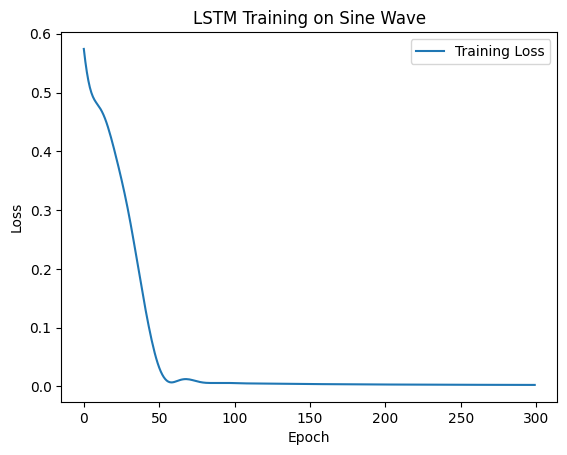

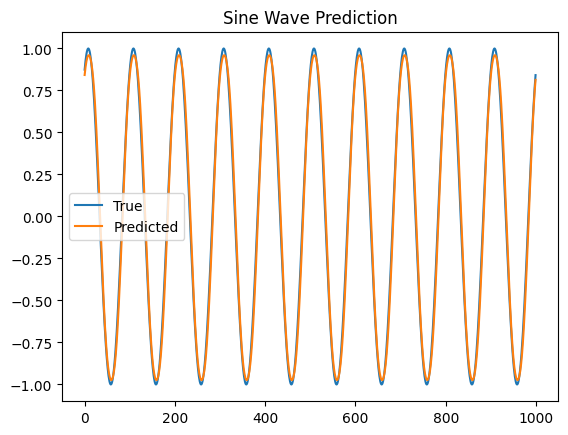

In [ ]:
model = LSTMRegressor(Qinput_dim, Qhidden_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()

# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('Sine Wave Prediction')
plt.show()

Using Classical LSTM
Epoch 10/300, Loss: 0.4170
Epoch 20/300, Loss: 0.2498
Epoch 30/300, Loss: 0.0528
Epoch 40/300, Loss: 0.0114
Epoch 50/300, Loss: 0.0082
Epoch 60/300, Loss: 0.0050
Epoch 70/300, Loss: 0.0025
Epoch 80/300, Loss: 0.0028
Epoch 90/300, Loss: 0.0024
Epoch 100/300, Loss: 0.0024
Epoch 110/300, Loss: 0.0024
Epoch 120/300, Loss: 0.0023
Epoch 130/300, Loss: 0.0023
Epoch 140/300, Loss: 0.0023
Epoch 150/300, Loss: 0.0023
Epoch 160/300, Loss: 0.0023
Epoch 170/300, Loss: 0.0023
Epoch 180/300, Loss: 0.0023
Epoch 190/300, Loss: 0.0023
Epoch 200/300, Loss: 0.0023
Epoch 210/300, Loss: 0.0023
Epoch 220/300, Loss: 0.0023
Epoch 230/300, Loss: 0.0023
Epoch 240/300, Loss: 0.0022
Epoch 250/300, Loss: 0.0022
Epoch 260/300, Loss: 0.0022
Epoch 270/300, Loss: 0.0022
Epoch 280/300, Loss: 0.0022
Epoch 290/300, Loss: 0.0022
Epoch 300/300, Loss: 0.0022


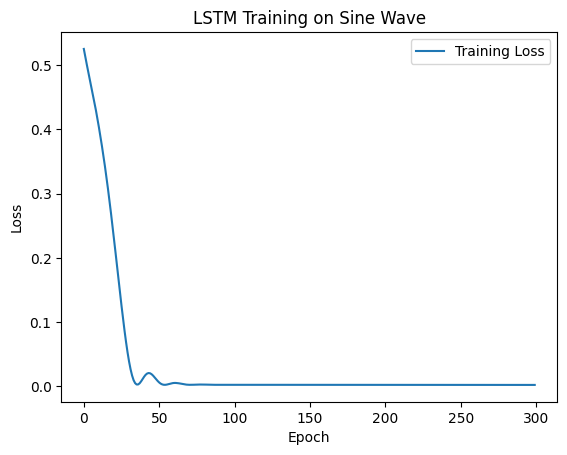

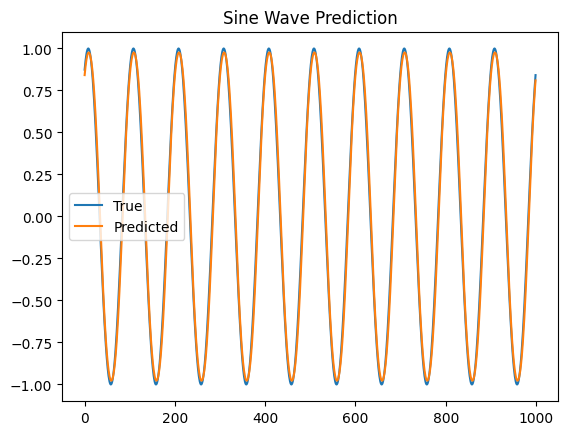

In [ ]:
# Model parameters
Cinput_dim = 1
Chidden_dim = 16
backend = 'default.qubit'
model = LSTMRegressor(Cinput_dim, Chidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()

# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('Sine Wave Prediction')
plt.show()

# 8 diminthion data sequances lenth 1 and 8 qubit

In [54]:
egihtdim=pd.read_csv('8sindata.csv')
egihtdim

,Wave1,Wave2,Wave3,Wave4,Wave5,Wave6,Wave7,Wave8
0,0.841471,0.841471,0.841471,0.841471,0.841471,0.841471,0.841471,0.841471
1,0.873736,0.873736,0.873736,0.873736,0.873736,0.873736,0.873736,0.873736
2,0.902554,0.902554,0.902554,0.902554,0.902554,0.902554,0.902554,0.902554
3,0.927809,0.927809,0.927809,0.927809,0.927809,0.927809,0.927809,0.927809
4,0.949402,0.949402,0.949402,0.949402,0.949402,0.949402,0.949402,0.949402
...,...,...,...,...,...,...,...,...
4996,0.680667,0.680667,0.680667,0.680667,0.680667,0.680667,0.680667,0.680667
4997,0.725324,0.725324,0.725324,0.725324,0.725324,0.725324,0.725324,0.725324
4998,0.767118,0.767118,0.767118,0.767118,0.767118,0.767118,0.767118,0.767118
4999,0.805885,0.805885,0.805885,0.805885,0.805885,0.805885,0.805885,0.805885


In [66]:
data = egihtdim.iloc[:, :8].values  # Extract first 8 columns as features

# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])  # (sequence_length, 8)
        labels.append(data[i + sequence_length])  # Keep next step as (8,)
    return np.array(sequences), np.array(labels)  # Now, labels will have shape (num_samples, 8)

# Define parameters
sequence_length = 1

# Create training data
X, y = create_sequences(data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_8_train, X_8_test = X[:train_size], X[train_size:]
y_8_train, y_8_test = y[:train_size], y[train_size:]

print(f"data X train shape: {X_8_train.shape},data X test shape: {X_8_test.shape}")
print(f"data y train shape: {y_8_train.shape},data y test shape: {y_8_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_8_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_8_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_8_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_8_test, dtype=torch.float32)


data X train shape: (4000, 1, 8),data X test shape: (1000, 1, 8)
data y train shape: (4000, 8),data y test shape: (1000, 8)


In [67]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output 8 predictions

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))
        output = self.fc(lstm_out[:, -1])  # Predict next values for all features
        return output

Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 8)
Epoch 10/300 Train Loss: 0.3545 | Val Loss: 0.3269 Train R²: 0.2910 | Val R²: 0.3462
Epoch 20/300 Train Loss: 0.1424 | Val Loss: 0.1221 Train R²: 0.7152 | Val R²: 0.7559
Epoch 30/300 Train Loss: 0.0227 | Val Loss: 0.0241 Train R²: 0.9546 | Val R²: 0.9518
Epoch 40/300 Train Loss: 0.0080 | Val Loss: 0.0078 Train R²: 0.9840 | Val R²: 0.9845
Epoch 50/300 Train Loss: 0.0054 | Val Loss: 0.0044 Train R²: 0.9892 | Val R²: 0.9913
Epoch 60/300 Train Loss: 0.0032 | Val Loss: 0.0030 Train R²: 0.9935 | Val R²: 0.9939
Epoch 70/300 Train Loss: 0.0025 | Val Loss: 0.0026 Train R²: 0.9950 | Val R²: 0.9948
Epoch 80/300 Train Loss: 0.0024 | Val Loss: 0.0024 Train R²: 0.9952 | Val R²: 0.9952
Epoch 90/300 Train Loss: 0.0022 | Val Loss: 0.0022 Train R²: 0.9955 | Val R²: 0.9955
Epoch 100/300 Train Loss: 0.0021 | Val Loss: 0.0021 Train R²: 0.9958 | Val R²: 0.9958
Epoch 110/300 Train Loss: 0.0021 | Val Loss: 0.0021 Train 

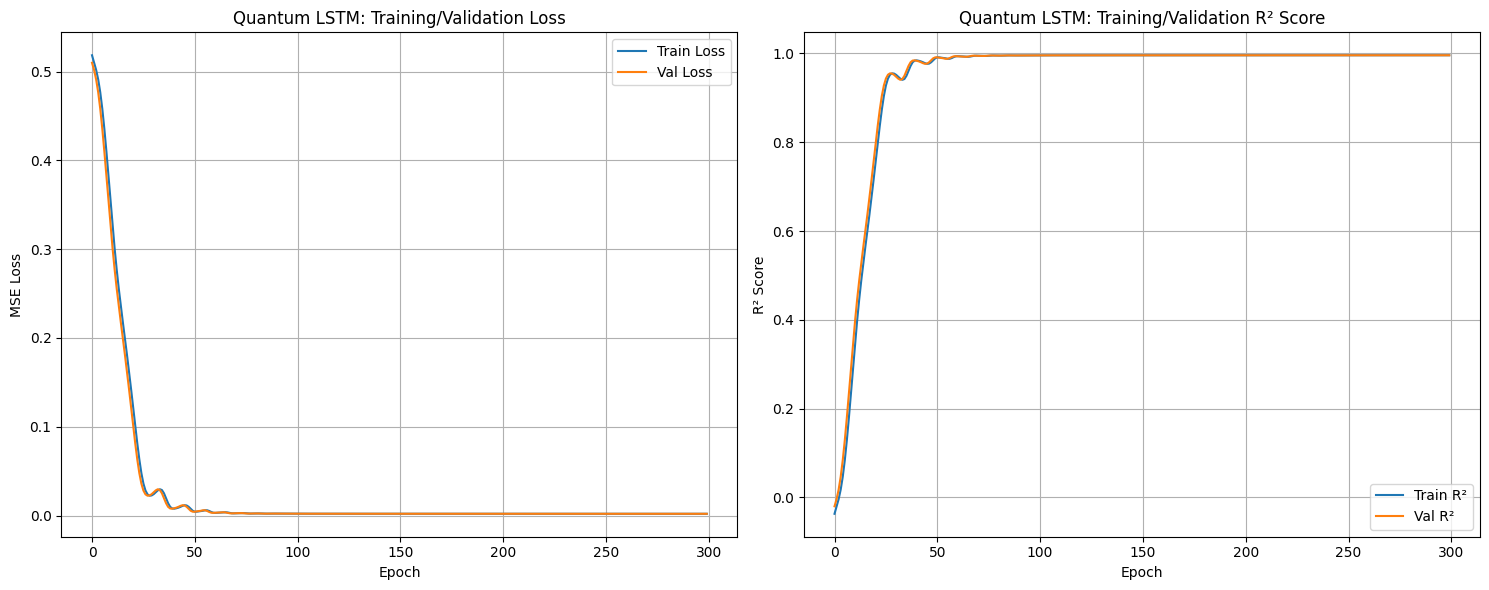

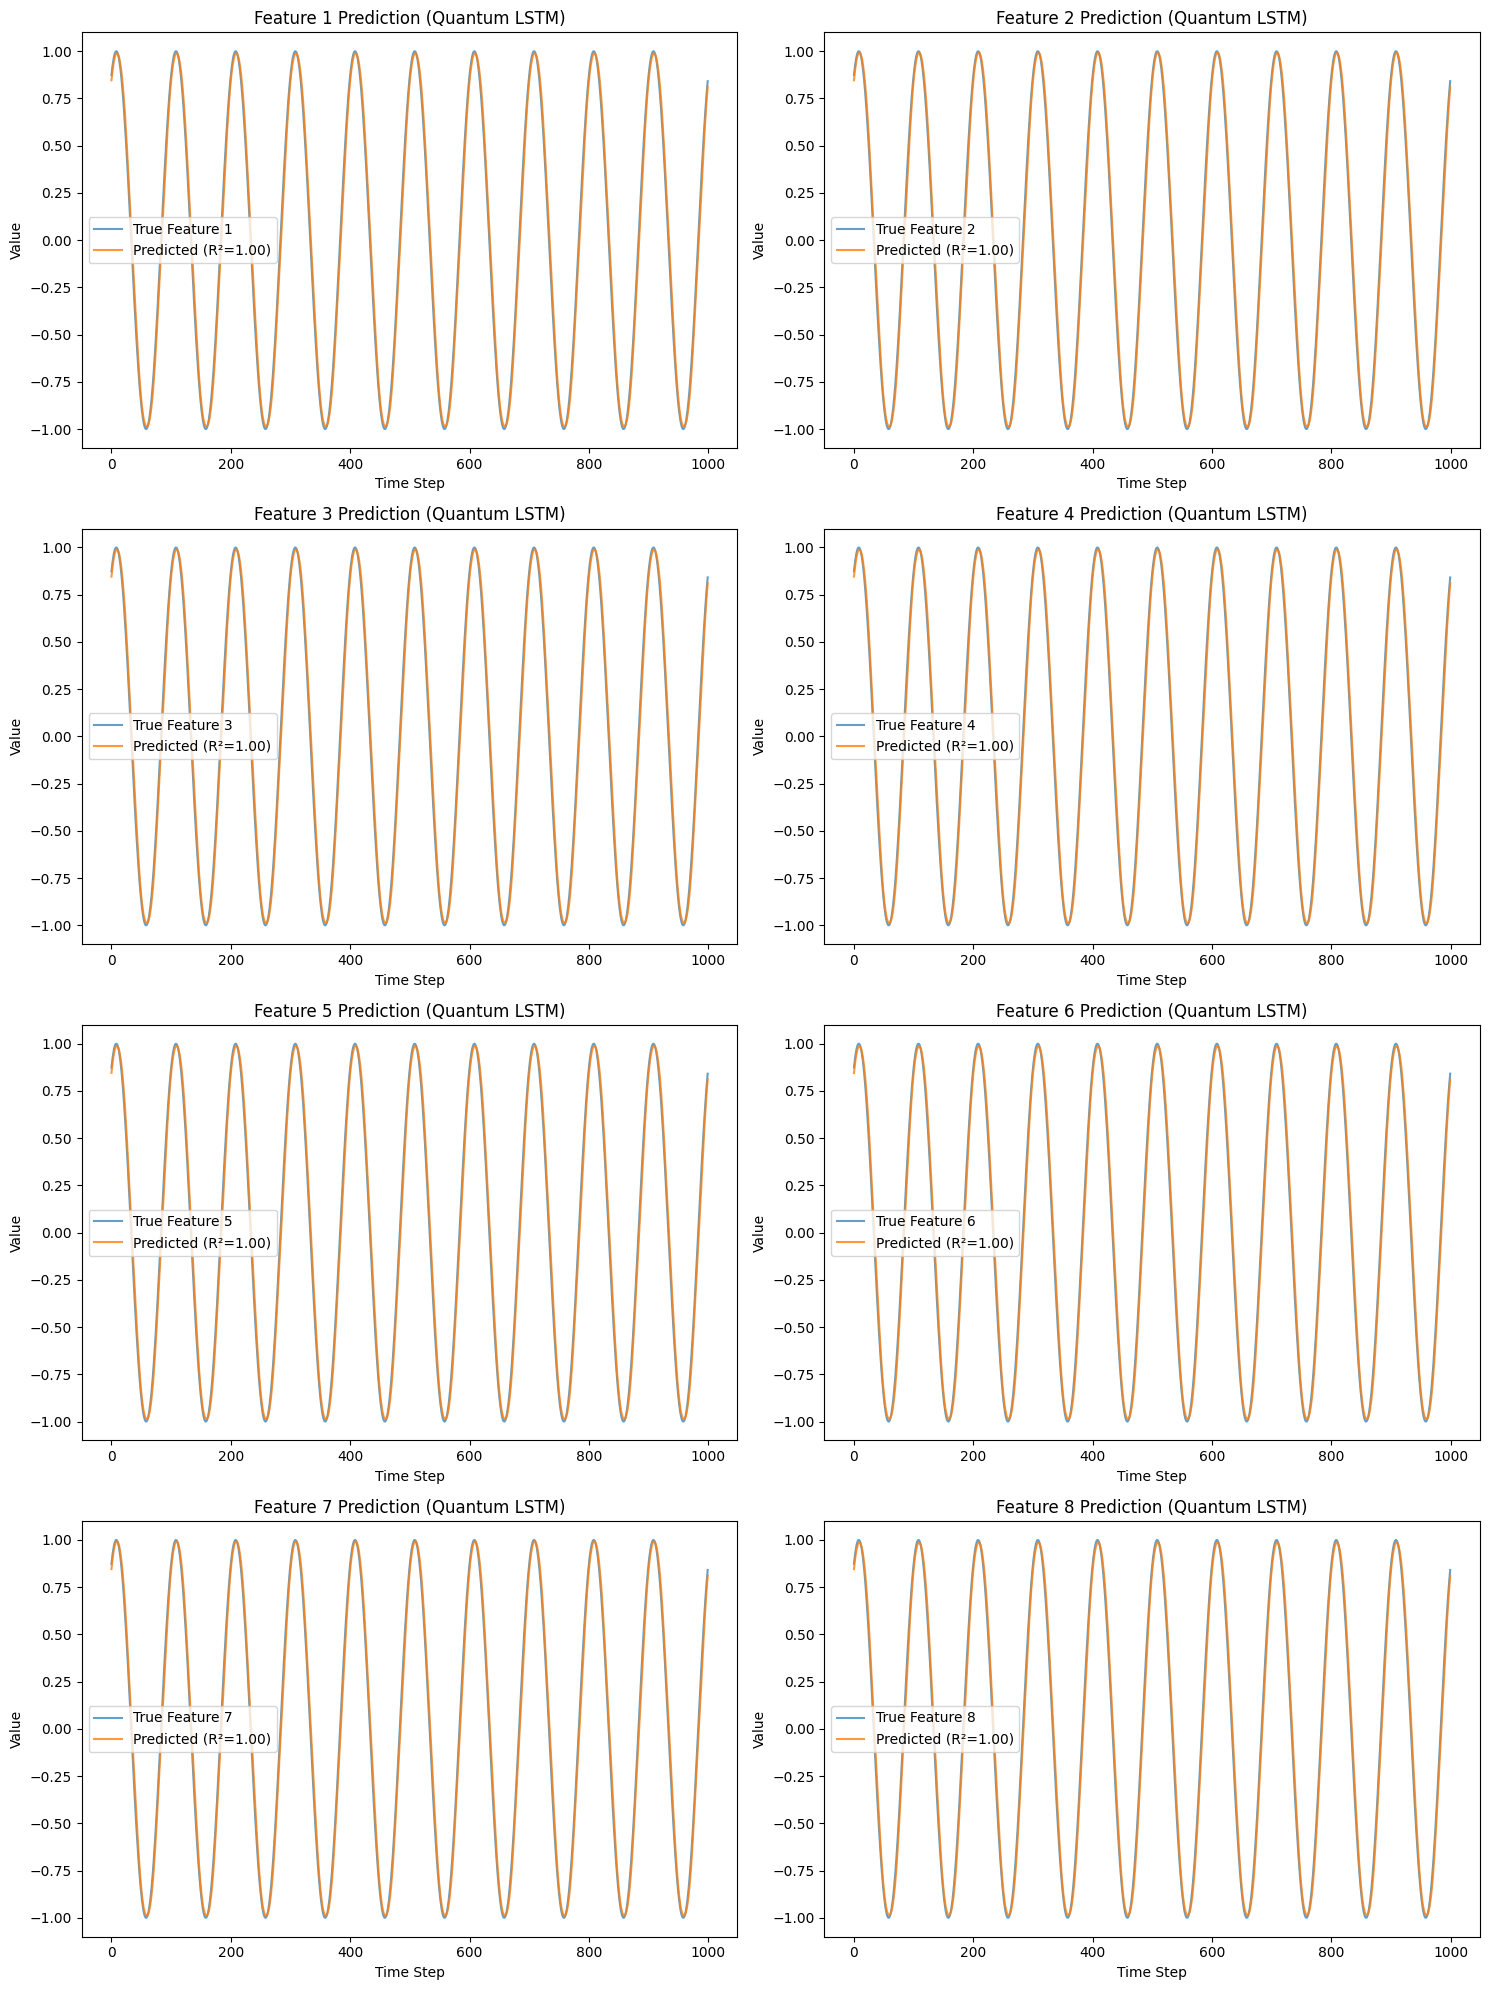


Quantum LSTM - Final Feature-wise Performance:
Feature 1: R² = 0.9960
Feature 2: R² = 0.9960
Feature 3: R² = 0.9960
Feature 4: R² = 0.9960
Feature 5: R² = 0.9960
Feature 6: R² = 0.9960
Feature 7: R² = 0.9960
Feature 8: R² = 0.9960


In [79]:
from sklearn.metrics import r2_score

# Quantum LSTM parameters
Qinput_dim = 8
Qhidden_dim = 32
Qn_qubits = 8
Qoutput_dim = 8
backend = 'default.qubit'
model = LSTMRegressor(Qinput_dim, Qhidden_dim, output_dim=Qoutput_dim, 
                     n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs, y_train_tensor)
    
    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np, train_preds, multioutput='uniform_average')
    
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs, y_test_tensor)
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np, val_preds, multioutput='uniform_average')
    
    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)
    
    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
# Plot metrics
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Quantum LSTM: Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Quantum LSTM: Training/Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(y_8_test[:, i], label=f'True Feature {i+1}', alpha=0.7)
    plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
    plt.title(f'Feature {i+1} Prediction (Quantum LSTM)')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nQuantum LSTM - Final Feature-wise Performance:")
for i, r2 in enumerate(feature_r2_scores):
    print(f"Feature {i+1}: R² = {r2:.4f}")

Using Classical LSTM
Epoch 10/300 Train Loss: 0.0782 | Val Loss: 0.0423 Train R²: 0.8436 | Val R²: 0.9155
Epoch 20/300 Train Loss: 0.0496 | Val Loss: 0.0381 Train R²: 0.9008 | Val R²: 0.9237
Epoch 30/300 Train Loss: 0.0195 | Val Loss: 0.0206 Train R²: 0.9610 | Val R²: 0.9589
Epoch 40/300 Train Loss: 0.0071 | Val Loss: 0.0075 Train R²: 0.9857 | Val R²: 0.9850
Epoch 50/300 Train Loss: 0.0068 | Val Loss: 0.0063 Train R²: 0.9863 | Val R²: 0.9873
Epoch 60/300 Train Loss: 0.0060 | Val Loss: 0.0056 Train R²: 0.9881 | Val R²: 0.9887
Epoch 70/300 Train Loss: 0.0046 | Val Loss: 0.0045 Train R²: 0.9907 | Val R²: 0.9911
Epoch 80/300 Train Loss: 0.0036 | Val Loss: 0.0035 Train R²: 0.9927 | Val R²: 0.9930
Epoch 90/300 Train Loss: 0.0028 | Val Loss: 0.0028 Train R²: 0.9943 | Val R²: 0.9944
Epoch 100/300 Train Loss: 0.0024 | Val Loss: 0.0024 Train R²: 0.9952 | Val R²: 0.9953
Epoch 110/300 Train Loss: 0.0022 | Val Loss: 0.0022 Train R²: 0.9956 | Val R²: 0.9957
Epoch 120/300 Train Loss: 0.0021 | Val Los

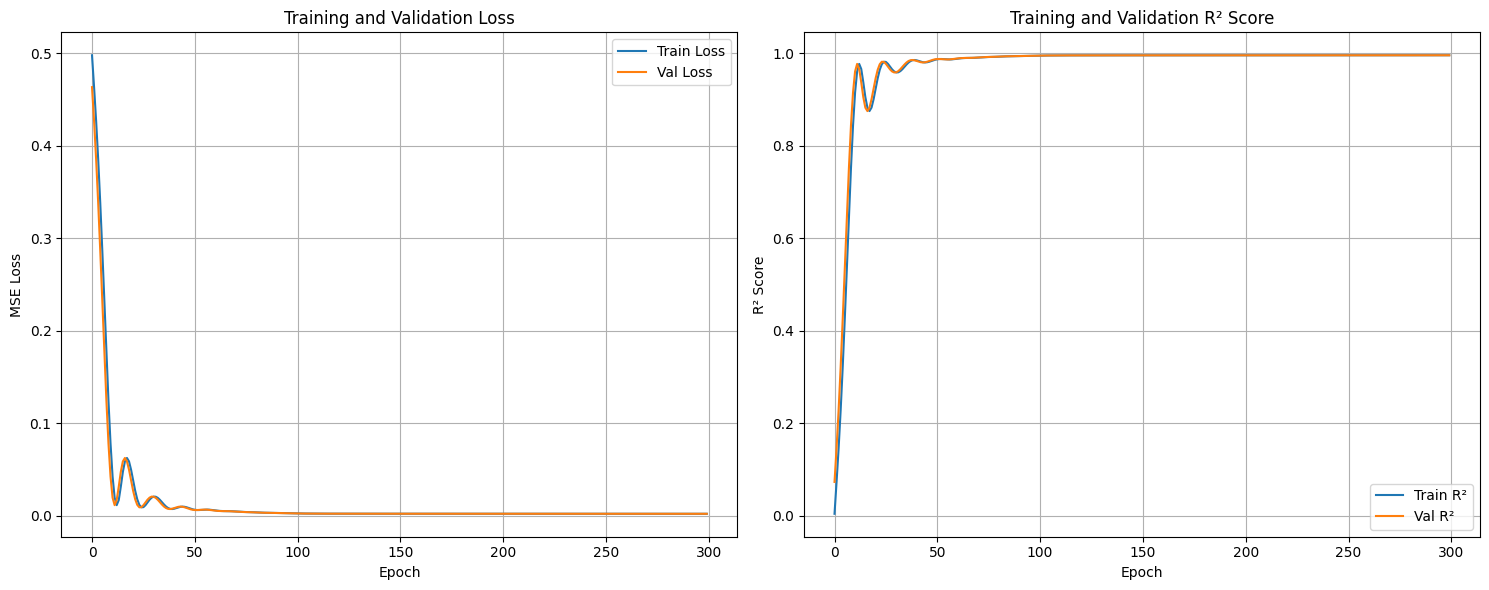

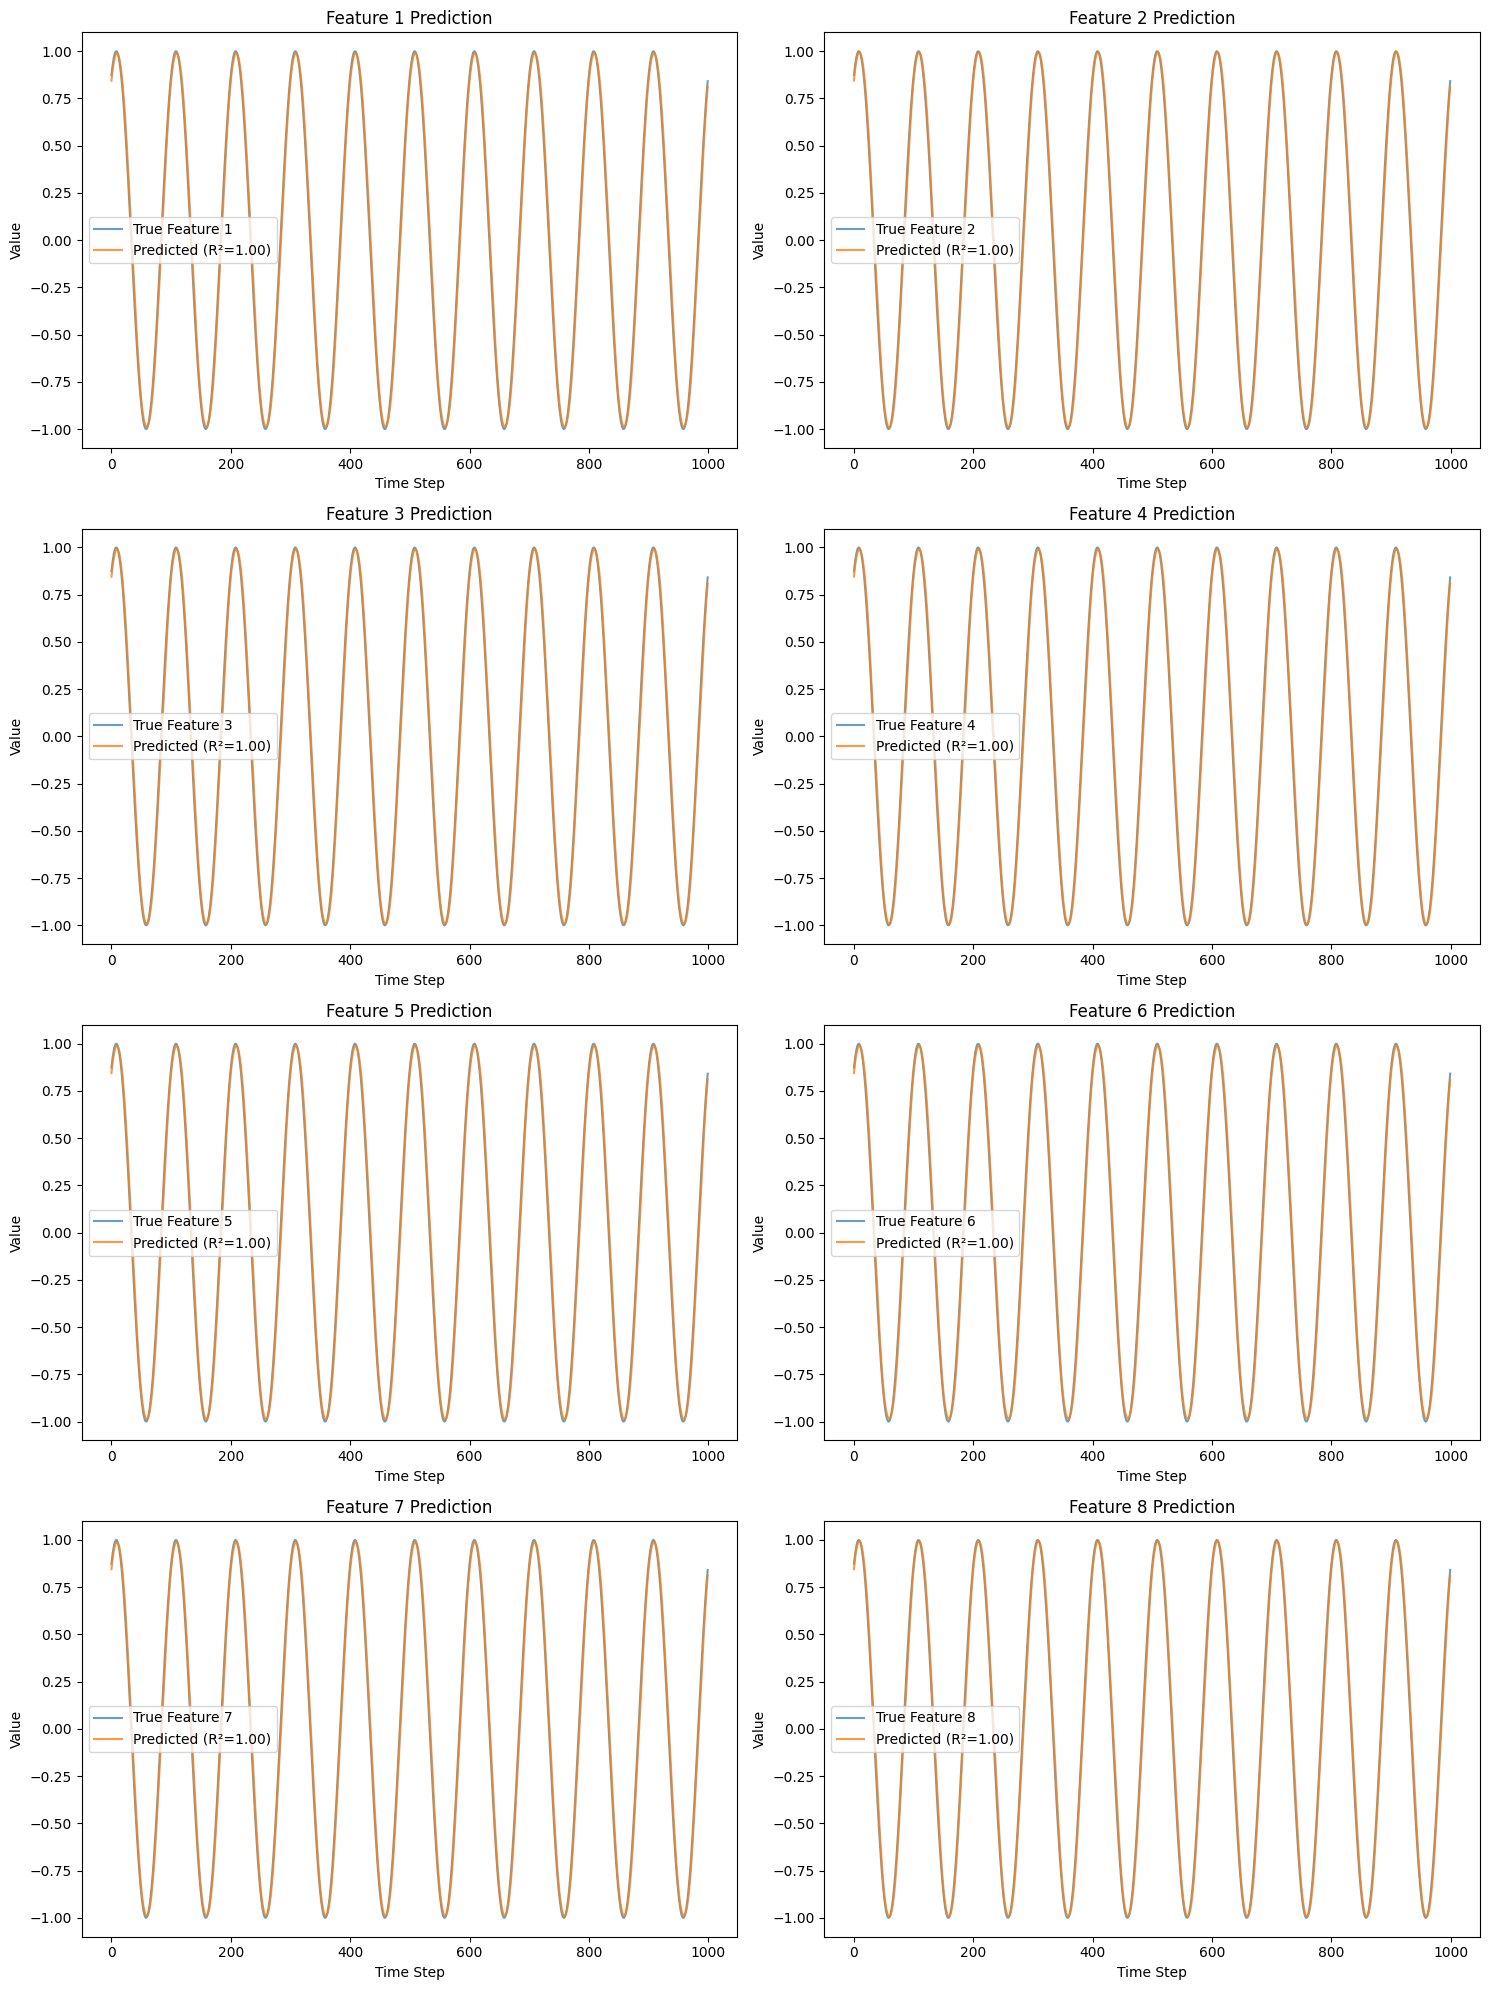


Final Feature-wise Performance:
Feature 1: R² = 0.9960
Feature 2: R² = 0.9960
Feature 3: R² = 0.9960
Feature 4: R² = 0.9960
Feature 5: R² = 0.9960
Feature 6: R² = 0.9960
Feature 7: R² = 0.9960
Feature 8: R² = 0.9960


In [78]:
from sklearn.metrics import r2_score

# Model parameters
Cinput_dim = 8
Chidden_dim = 32
backend = 'default.qubit'
model = LSTMRegressor(Cinput_dim, Chidden_dim, output_dim=8)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 300
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs, y_train_tensor)
    
    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np, train_preds, multioutput='uniform_average')
    
    train_loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs, y_test_tensor)
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np, val_preds, multioutput='uniform_average')
    
    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)
    
    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
# Plot metrics
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Training and Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# Calculate R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.plot(y_8_test[:, i], label=f'True Feature {i+1}', alpha=0.7)
    plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
    plt.title(f'Feature {i+1} Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nFinal Feature-wise Performance:")
for i, r2 in enumerate(feature_r2_scores):
    print(f"Feature {i+1}: R² = {r2:.4f}")

# 2 layer qubit 1

In [50]:
# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)
# Initialize variables
sequence_length =1

# Make a copy of the original DataFrame to update
updated_data = data['Wave'].copy()

X, y = create_sequences(updated_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"data X train shape: {X_train.shape},data X test shape: {X_test.shape}")
print(f"data y train shape: {y_train.shape},data y test shape: {y_test.shape}")
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
# Model parameters
Qinput_dim = 1
Qhidden_dim = 16
Qn_qubits = 1
Qn_layers = 2
backend = 'default.qubit'
model = LSTMRegressor(Qinput_dim, Qhidden_dim, n_qubits=Qn_qubits,n_qlayers=Qn_layers, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

data X train shape: (4000, 1),data X test shape: (1000, 1)
data y train shape: (4000,),data y test shape: (1000,)
Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (2, 1)


Epoch 10/300, Loss: 0.5065, Average Loss: 0.5498
Epoch 20/300, Loss: 0.5047, Average Loss: 0.5261
Epoch 30/300, Loss: 0.4973, Average Loss: 0.5180
Epoch 40/300, Loss: 0.4689, Average Loss: 0.5097
Epoch 50/300, Loss: 0.3719, Average Loss: 0.4926
Epoch 60/300, Loss: 0.1667, Average Loss: 0.4547
Epoch 70/300, Loss: 0.0092, Average Loss: 0.3990
Epoch 80/300, Loss: 0.0240, Average Loss: 0.3510
Epoch 90/300, Loss: 0.0057, Average Loss: 0.3135
Epoch 100/300, Loss: 0.0064, Average Loss: 0.2827
Epoch 110/300, Loss: 0.0044, Average Loss: 0.2575
Epoch 120/300, Loss: 0.0041, Average Loss: 0.2364
Epoch 130/300, Loss: 0.0037, Average Loss: 0.2185
Epoch 140/300, Loss: 0.0035, Average Loss: 0.2032
Epoch 150/300, Loss: 0.0034, Average Loss: 0.1898
Epoch 160/300, Loss: 0.0033, Average Loss: 0.1782
Epoch 170/300, Loss: 0.0032, Average Loss: 0.1679
Epoch 180/300, Loss: 0.0031, Average Loss: 0.1587
Epoch 190/300, Loss: 0.0031, Average Loss: 0.1506
Epoch 200/300, Loss: 0.0030, Average Loss: 0.1432
Epoch 210

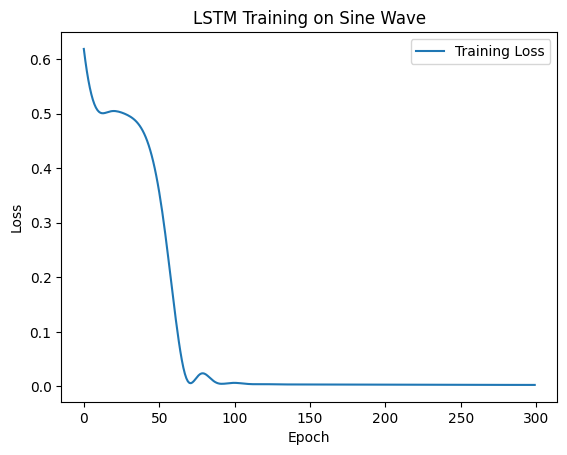

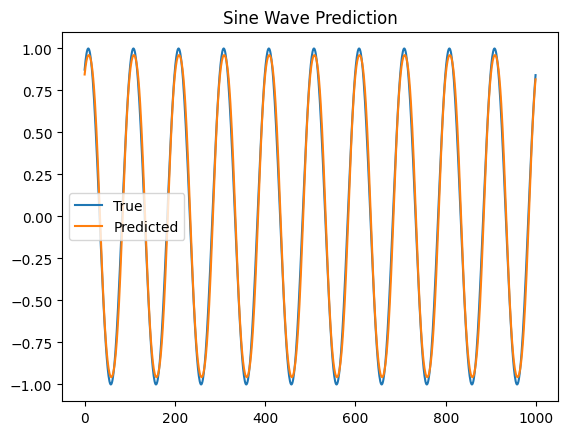

In [51]:
# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        avg_loss = sum(loss_history) / len(loss_history)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Average Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()

# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('Sine Wave Prediction')
plt.show()

Using Classical LSTM
Epoch 10/300, Loss: 0.4146, Average Loss: 0.4657
Epoch 20/300, Loss: 0.2441, Average Loss: 0.3968
Epoch 30/300, Loss: 0.0446, Average Loss: 0.3077
Epoch 40/300, Loss: 0.0142, Average Loss: 0.2335
Epoch 50/300, Loss: 0.0061, Average Loss: 0.1899
Epoch 60/300, Loss: 0.0052, Average Loss: 0.1589
Epoch 70/300, Loss: 0.0022, Average Loss: 0.1367
Epoch 80/300, Loss: 0.0026, Average Loss: 0.1199
Epoch 90/300, Loss: 0.0022, Average Loss: 0.1068
Epoch 100/300, Loss: 0.0022, Average Loss: 0.0964
Epoch 110/300, Loss: 0.0022, Average Loss: 0.0878
Epoch 120/300, Loss: 0.0022, Average Loss: 0.0807
Epoch 130/300, Loss: 0.0022, Average Loss: 0.0746
Epoch 140/300, Loss: 0.0022, Average Loss: 0.0695
Epoch 150/300, Loss: 0.0022, Average Loss: 0.0650
Epoch 160/300, Loss: 0.0022, Average Loss: 0.0611
Epoch 170/300, Loss: 0.0022, Average Loss: 0.0576
Epoch 180/300, Loss: 0.0022, Average Loss: 0.0545
Epoch 190/300, Loss: 0.0022, Average Loss: 0.0518
Epoch 200/300, Loss: 0.0022, Average L

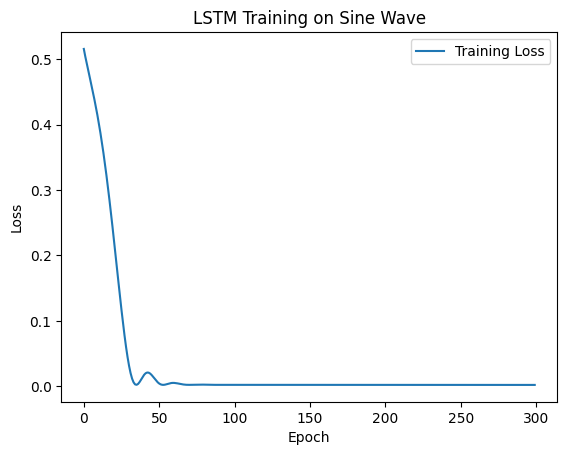

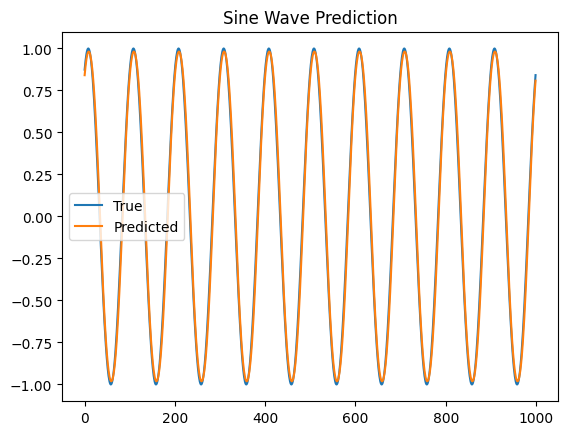

In [52]:
# Model parameters
Cinput_dim = 1
Chidden_dim = 16
model = LSTMRegressor(Cinput_dim, Chidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop
num_epochs = 300
loss_history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        avg_loss = sum(loss_history) / len(loss_history)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Average Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training on Sine Wave')
plt.legend()
plt.show()

# Predict and visualize
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_test)), y_pred, label='Predicted')
plt.legend()
plt.title('Sine Wave Prediction')
plt.show()